In [ ]:
!pip install -q kaggle

In [ ]:
import pandas as pd
import random
from random import randrange
from matplotlib import pyplot as plt
import numpy as np

Download and unzip Kaggle dataset

In [ ]:
 # upload the kaggle.json file provided
 # if doesn't work for some reason see https://www.kaggle.com/general/74235 to create new api key

 from google.colab import files 
 files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ujandeb","key":"9de9f735d28f4c4507a802d6fd74c937"}'}

In [ ]:
# create a directory for the kaggle api key

!mkdir ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d jsrojas/labeled-network-traffic-flows-114-applications
!unzip /content/labeled-network-traffic-flows-114-applications.zip

 99% 357M/362M [00:04<00:00, 105MB/s] 
100% 362M/362M [00:04<00:00, 91.6MB/s]
Archive:  /content/labeled-network-traffic-flows-114-applications.zip
  inflating: Unicauca-dataset-April-June-2019-Network-flows.csv  


Loading dataset into pandas dataframe

In [ ]:
df = pd.read_csv('/content/Unicauca-dataset-April-June-2019-Network-flows.csv', engine='c')
df.head()

,flow_key,src_ip_numeric,src_ip,src_port,dst_ip,dst_port,proto,pktTotalCount,octetTotalCount,min_ps,max_ps,avg_ps,std_dev_ps,flowStart,flowEnd,flowDuration,min_piat,max_piat,avg_piat,std_dev_piat,f_pktTotalCount,f_octetTotalCount,f_min_ps,f_max_ps,f_avg_ps,f_std_dev_ps,f_flowStart,f_flowEnd,f_flowDuration,f_min_piat,f_max_piat,f_avg_piat,f_std_dev_piat,b_pktTotalCount,b_octetTotalCount,b_min_ps,b_max_ps,b_avg_ps,b_std_dev_ps,b_flowStart,b_flowEnd,b_flowDuration,b_min_piat,b_max_piat,b_avg_piat,b_std_dev_piat,flowEndReason,category,application_protocol,web_service
0,3acee4f4ea001cd5e6d9584d4036b53d,3232266497,192.168.121.1,67,172.16.255.185,67,17,22,7620,328,394,346.363636,25.010081,1.555954e+09,1.555955e+09,1701.385427,0.000313,198.656500,81.018354,78.913442,17,5670,328,354,333.529412,9.140200,1.555954e+09,1.555955e+12,1701.385427,0.010463,198.657170,106.336589,74.034708,5,1950,389,394,390.000000,2.000000,1.555955e+09,1.555955e+09,1.554399e+12,0.010354,198.657965,51.689181,84.916348,2,Network,Unknown,DHCP
1,974ec5991b439c9a7176b88be0c90df0,3232266497,192.168.121.1,67,172.16.255.186,67,17,17,5670,328,354,333.529412,9.140200,1.555954e+09,1.555955e+09,1701.385515,0.010356,198.657267,106.336595,74.034707,17,5670,328,354,333.529412,9.140200,1.555954e+09,1.555955e+12,1701.385515,0.010356,198.657267,106.336595,74.034707,0,0,0,0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2,Network,Unknown,DHCP
2,3acee4f4ea001cd5e6d9584d4036b53d,3232266497,192.168.121.1,67,172.16.255.185,67,17,43,15124,328,394,351.720930,26.098495,1.555964e+09,1.555965e+09,1450.967340,0.000239,248.424737,34.546841,58.972989,30,10062,328,352,335.400000,9.718024,1.555964e+09,1.555965e+12,1450.967340,0.015413,248.424737,50.033357,65.290032,13,5062,389,394,389.384615,1.332347,1.555964e+09,1.555965e+09,1.554409e+12,0.022332,340.268454,89.927588,124.270745,2,Network,Unknown,DHCP
3,974ec5991b439c9a7176b88be0c90df0,3232266497,192.168.121.1,67,172.16.255.186,67,17,30,10086,328,352,336.200000,10.057833,1.555964e+09,1.555965e+09,1450.967130,0.015330,248.424689,50.033349,65.510537,30,10086,328,352,336.200000,10.057833,1.555964e+09,1.555965e+12,1450.967130,0.015330,248.424689,50.033349,65.510537,0,0,0,0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2,Network,Unknown,DHCP
4,cfa7c2740072befaa89c202499729e08,3232266497,192.168.121.1,0,10.130.1.166,0,1,1,56,56,56,56.000000,0.000000,1.555966e+09,1.555966e+09,0.000000,0.000000,0.000000,0.000000,0.000000,1,56,56,56,56.000000,0.000000,1.555966e+09,1.555966e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2,Network,Unknown,ICMP


All the fields of each flow

In [ ]:
df.columns

Index(['flow_key', 'src_ip_numeric', 'src_ip', 'src_port', 'dst_ip',
       'dst_port', 'proto', 'pktTotalCount', 'octetTotalCount', 'min_ps',
       'max_ps', 'avg_ps', 'std_dev_ps', 'flowStart', 'flowEnd',
       'flowDuration', 'min_piat', 'max_piat', 'avg_piat', 'std_dev_piat',
       'f_pktTotalCount', 'f_octetTotalCount', 'f_min_ps', 'f_max_ps',
       'f_avg_ps', 'f_std_dev_ps', 'f_flowStart', 'f_flowEnd',
       'f_flowDuration', 'f_min_piat', 'f_max_piat', 'f_avg_piat',
       'f_std_dev_piat', 'b_pktTotalCount', 'b_octetTotalCount', 'b_min_ps',
       'b_max_ps', 'b_avg_ps', 'b_std_dev_ps', 'b_flowStart', 'b_flowEnd',
       'b_flowDuration', 'b_min_piat', 'b_max_piat', 'b_avg_piat',
       'b_std_dev_piat', 'flowEndReason', 'category', 'application_protocol',
       'web_service'],
      dtype='object')

Implement the reservoir sampling method and maintain 10 reservoirs of size 1000 
flows each. After processing all the flows, plot the histograms of pktTotalCount, avg_ps and flowDuration. Comment if the histograms are similar across the 10 reservoirs (samples). If we use any one of these samples as a batch for SGD algorithm to build a regression model to estimate 
the  data  consumption  by  a  given  user,  how  good  would  it  be?  Can  you  think  of  better  ways  to  make batches in the streaming model for SGD (where memory is constrained)? 

Class and function defintions for flow and reservoir objects

In [ ]:
class Flow:

  def __init__(self, pktTotalCount, avg_ps, flowDuration):
    self.pktTotalCount = pktTotalCount
    self.avg_ps = avg_ps
    self.flowDuration = flowDuration


class Reservoir:

  def __init__(self):
    self.res = set()
    self.full = False

  def reservoir_size(self):
    return len(self.res)


def build_flow(row):
  # extracting the required fields
  pktTotalCount = row['f_pktTotalCount']
  avg_ps = row['f_avg_ps']
  flowDuration = row['flowDuration']
  flow = Flow(pktTotalCount, avg_ps, flowDuration)

  return flow

Building a list of reservoirs and filling them

In [ ]:
num_res = 10  # number of reservoirs
res_size = 1000 # size of each reservoir
reservoirs = [] # list to store reservoir objects

for i in range(num_res):  # creating reservoirs to store flows
  reservoirs.append(Reservoir())


# filling the reservoirs upto max capacity

full = False  # check if all reservoirs are full
for index, row in df.iterrows():

  flow = build_flow(row)  # building flow object

  for i in range(num_res + 1):
    if i == num_res:  # all reservoirs full
      full = True
      break
    if not reservoirs[i].full: # ith reservoir has space
      reservoirs[i].res.add(flow) # add flow to reservoir
      if len(reservoirs[i].res) == res_size: 
        reservoirs[i].full = True  # reservoir limit reached
      break

  if full:   # check if all reservoirs are full
    print('All reservoirs full')
    break

# the remaining dataframe
rest = df.iloc[index:, :]

All reservoirs full


Applying reservoir sampling on the rest of the stream

In [ ]:
for index, row in rest.iterrows():

  flow = build_flow(row)  # building flow object

  res_id = randrange(10)  # randomly select a reservoir
  size = reservoirs[res_id].reservoir_size()  # current size of reservoir

  n = size + index + 1 
  prob = size / n # s/n

  if random.uniform(0, 1) <= prob:  # keep with probability s/n
    keep = True
  else: keep = False

  if keep:  # keep flow and discard random flow
    el = random.sample(reservoirs[res_id].res, 1)[0]  # randomly select a flow
    reservoirs[res_id].res.remove(el) # discard random flow
    reservoirs[res_id].res.add(flow)  # add flow

Plotting histograms

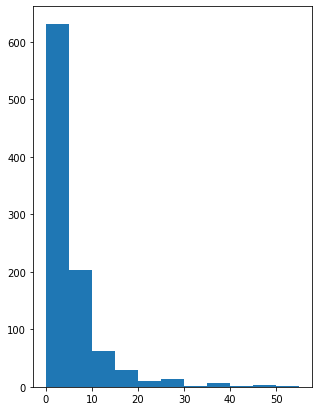

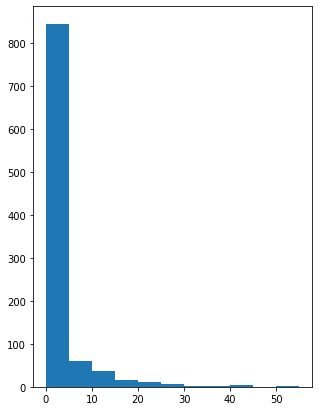

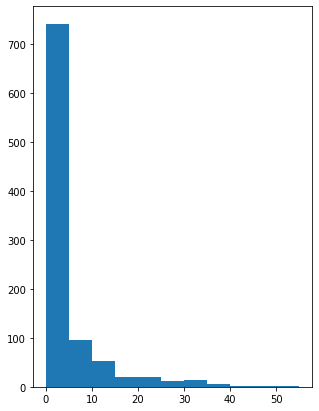

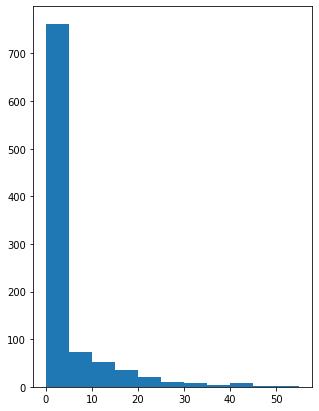

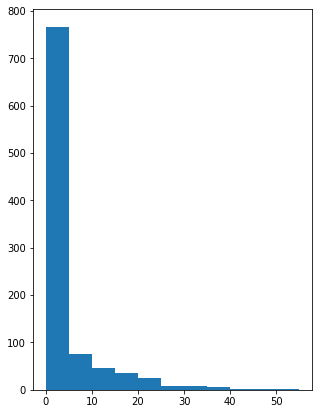

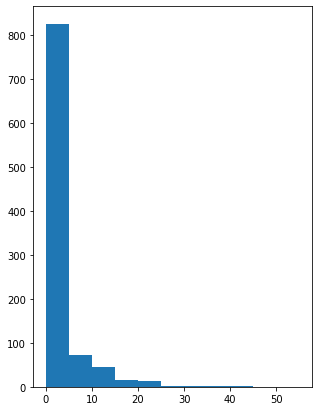

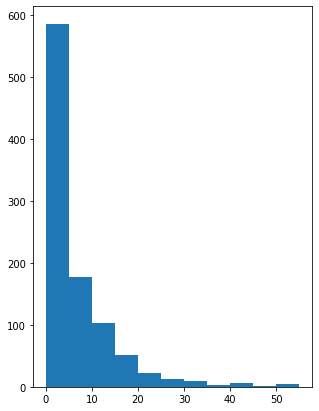

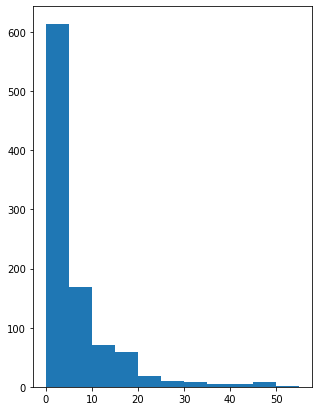

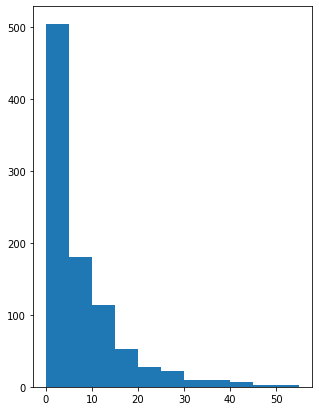

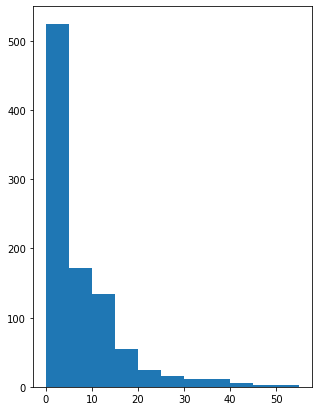

In [ ]:
# pktTotalCount histograms

histograms = []
for i in range(num_res):
  l = []
  for flow in reservoirs[i].res:
    l.append(flow.pktTotalCount)
  a = np.array(l)
  fig, ax = plt.subplots(figsize =(5, 7))
  ax.hist(a, bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55])
  
plt.show()

There are slight differences between the histograms

The current batches are random samples from usage data of all users. A better way to fit a regression model perhaps would be to sample data from a fixed set of users (from the IP addresses) and then use the samples as batches for SGD. 